<a href="https://colab.research.google.com/github/fjadidi2001/Cyber-Attack-Detection/blob/main/satellite.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cell 1: Setup and Dataset Download



100%|██████████| 21.8M/21.8M [00:00<00:00, 178MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mahmoudreda55/satellite-image-classification/versions/1


,Category,Image Count
0,cloudy,1500
1,desert,1131
2,green_area,1500
3,water,1500


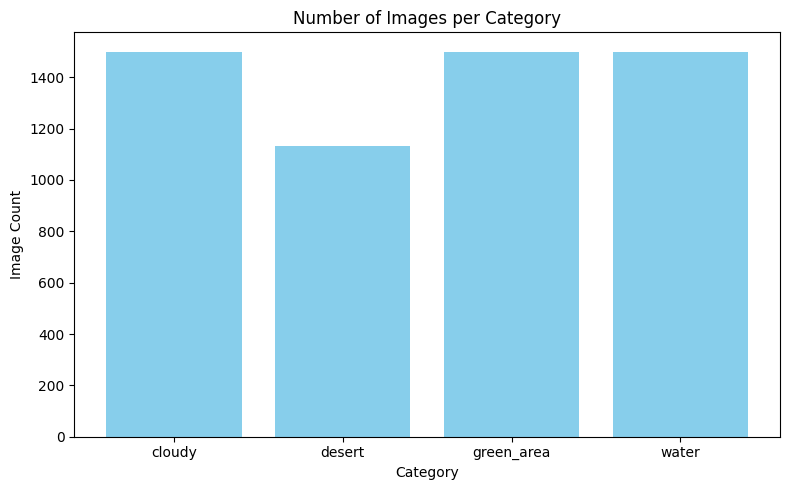

In [2]:
# Install required libraries
!pip install kagglehub opencv-python scikit-image pandas matplotlib -q

# Import libraries
import kagglehub
import os
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import numpy as np
from skimage.filters import threshold_otsu

# Download the dataset
path = kagglehub.dataset_download("mahmoudreda55/satellite-image-classification")
print("Path to dataset files:", path)

# List dataset contents
data_dir = os.path.join(path, "data")
categories = ['cloudy', 'desert', 'green_area', 'water']
file_counts = {cat: len(os.listdir(os.path.join(data_dir, cat))) for cat in categories}

# Output: Table of dataset contents
dataset_data = {
    'Category': categories,
    'Image Count': [file_counts[cat] for cat in categories]
}
dataset_df = pd.DataFrame(dataset_data)
display(dataset_df)

# Output: Bar chart of image counts per category
plt.figure(figsize=(8, 5))
plt.bar(dataset_df['Category'], dataset_df['Image Count'], color='skyblue')
plt.title('Number of Images per Category')
plt.xlabel('Category')
plt.ylabel('Image Count')
plt.tight_layout()
plt.show()

# Cell 2: Load and Preprocess Sample Images



,Category,Shape,Mean Pixel Value
0,cloudy,"(128, 128, 3)",0.394082
1,desert,"(128, 128, 3)",0.609715
2,green_area,"(128, 128, 3)",0.232975
3,water,"(128, 128, 3)",0.262604


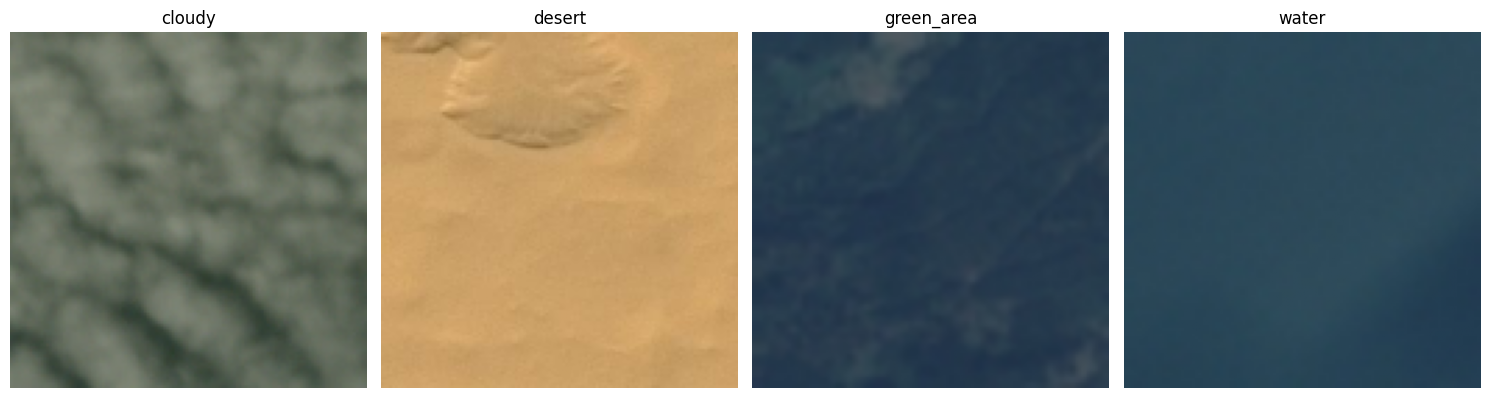

In [4]:
# Function to load and preprocess an image
def load_image(category, index=0):
    folder = os.path.join(data_dir, category)
    img_path = os.path.join(folder, os.listdir(folder)[index])
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, (128, 128))  # Resize for memory efficiency
    img = img / 255.0  # Normalize to [0, 1]
    return img

# Load one sample image per category
sample_images = {cat: load_image(cat) for cat in categories}

# Output: Table of sample image properties
image_data = {
    'Category': categories,
    'Shape': [sample_images[cat].shape for cat in categories],
    'Mean Pixel Value': [np.mean(sample_images[cat]) for cat in categories]
}
image_df = pd.DataFrame(image_data)
display(image_df)

# Output: Display sample images
fig, axes = plt.subplots(1, 4, figsize=(15, 4))
for i, cat in enumerate(categories):
    axes[i].imshow(sample_images[cat])
    axes[i].set_title(cat)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

# Cell 3: Vegetation Segmentation Using Green Channel



,Image,Otsu Threshold,Vegetation Area (km²)
0,Green Area,0.254963,0.1970
1,Desert,0.607744,1.4741


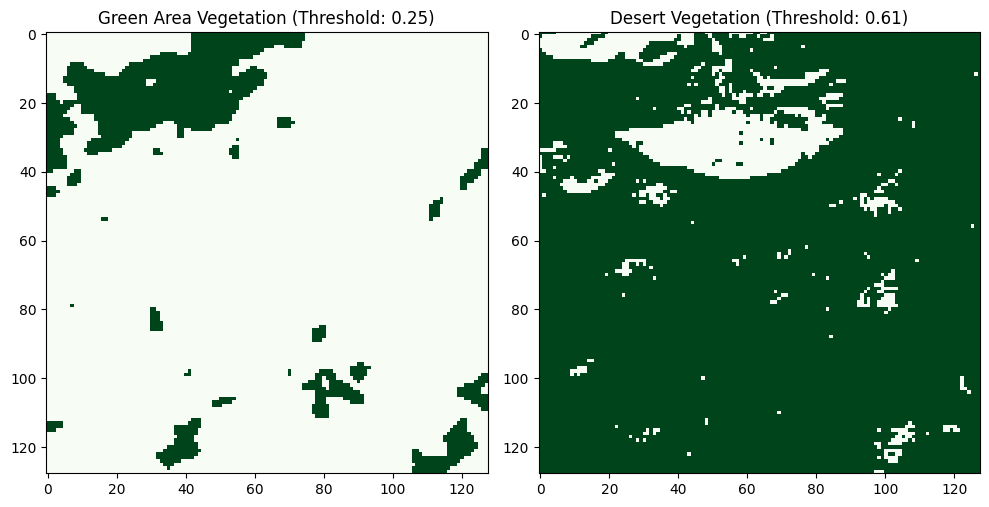

In [5]:
# Function to segment vegetation using green channel
def segment_vegetation(img):
    green_channel = img[:, :, 1]  # Green channel (RGB)
    threshold = threshold_otsu(green_channel)
    vegetation_mask = green_channel > threshold
    return vegetation_mask, threshold

# Segment vegetation for green_area and desert samples
veg_mask_green, thresh_green = segment_vegetation(sample_images['green_area'])
veg_mask_desert, thresh_desert = segment_vegetation(sample_images['desert'])

# Calculate vegetation area (assuming 10m resolution per pixel for estimation)
pixel_area_km2 = (10 * 10) / 1e6  # 10m x 10m pixels
veg_area_green = np.sum(veg_mask_green) * pixel_area_km2
veg_area_desert = np.sum(veg_mask_desert) * pixel_area_km2

# Output: Table of vegetation segmentation results
veg_data = {
    'Image': ['Green Area', 'Desert'],
    'Otsu Threshold': [thresh_green, thresh_desert],
    'Vegetation Area (km²)': [veg_area_green, veg_area_desert]
}
veg_df = pd.DataFrame(veg_data)
display(veg_df)

# Output: Vegetation segmentation maps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(veg_mask_green, cmap='Greens')
ax1.set_title(f'Green Area Vegetation (Threshold: {thresh_green:.2f})')
ax2.imshow(veg_mask_desert, cmap='Greens')
ax2.set_title(f'Desert Vegetation (Threshold: {thresh_desert:.2f})')
plt.tight_layout()
plt.show()

# Cell 4: Water Segmentation Using Blue Channel

,Image,Otsu Threshold,Water Area (km²)
0,Water,0.337263,1.3023
1,Cloudy,0.356725,1.0029


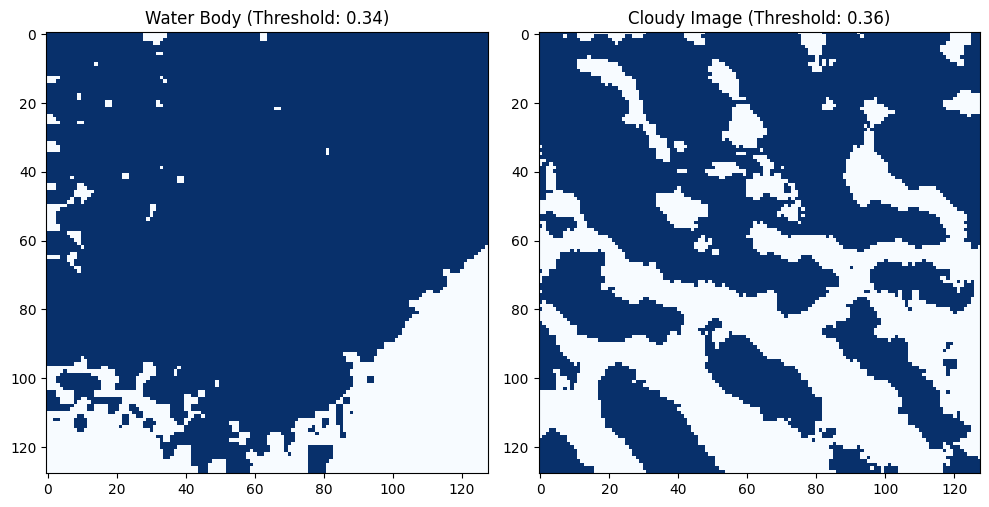

In [6]:
# Function to segment water using blue channel
def segment_water(img):
    blue_channel = img[:, :, 2]  # Blue channel (RGB)
    threshold = threshold_otsu(blue_channel)
    water_mask = blue_channel > threshold
    return water_mask, threshold

# Segment water for water and cloudy samples
water_mask_water, thresh_water = segment_water(sample_images['water'])
water_mask_cloudy, thresh_cloudy = segment_water(sample_images['cloudy'])

# Calculate water area
water_area_water = np.sum(water_mask_water) * pixel_area_km2
water_area_cloudy = np.sum(water_mask_cloudy) * pixel_area_km2

# Output: Table of water segmentation results
water_data = {
    'Image': ['Water', 'Cloudy'],
    'Otsu Threshold': [thresh_water, thresh_cloudy],
    'Water Area (km²)': [water_area_water, water_area_cloudy]
}
water_df = pd.DataFrame(water_data)
display(water_df)

# Output: Water segmentation maps
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(water_mask_water, cmap='Blues')
ax1.set_title(f'Water Body (Threshold: {thresh_water:.2f})')
ax2.imshow(water_mask_cloudy, cmap='Blues')
ax2.set_title(f'Cloudy Image (Threshold: {thresh_cloudy:.2f})')
plt.tight_layout()
plt.show()

# Cell 5: Environmental Analysis Summary



,Category,Vegetation Area (km²),Water Area (km²),Non-Environmental Area (km²)
0,Green Area,0.1970,0.0000,1.4414
1,Desert,1.4741,0.0000,0.1643
2,Water,0.0000,1.3023,0.3361
3,Cloudy,0.0000,1.0029,0.6355


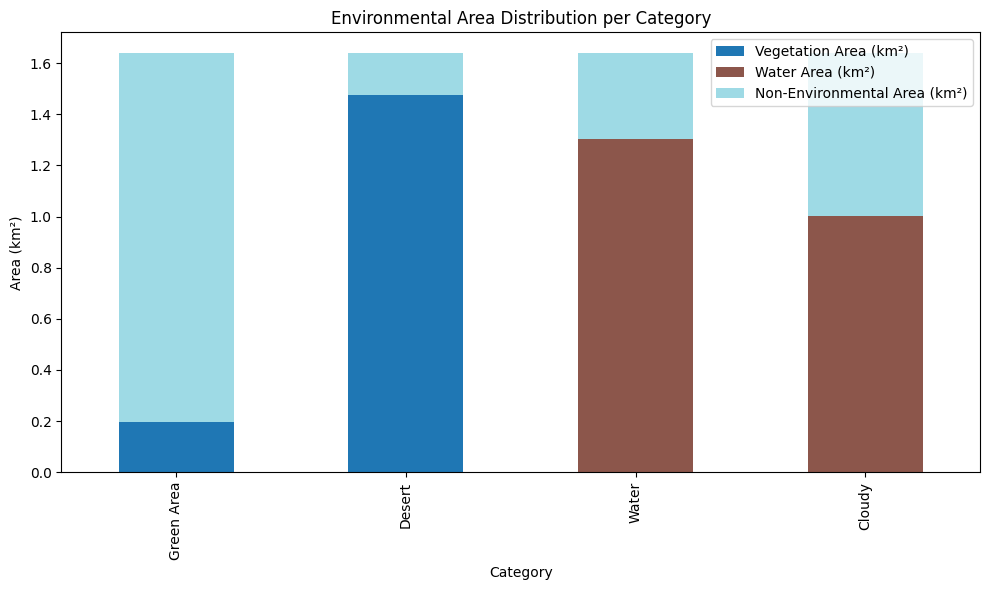

In [7]:
# Summarize environmental metrics
total_area = 128 * 128 * pixel_area_km2  # Total image area (128x128 pixels)
summary_data = {
    'Category': ['Green Area', 'Desert', 'Water', 'Cloudy'],
    'Vegetation Area (km²)': [veg_area_green, veg_area_desert, 0, 0],
    'Water Area (km²)': [0, 0, water_area_water, water_area_cloudy],
    'Non-Environmental Area (km²)': [total_area - veg_area_green, total_area - veg_area_desert,
                                     total_area - water_area_water, total_area - water_area_cloudy]
}
summary_df = pd.DataFrame(summary_data)
display(summary_df)

# Output: Stacked bar chart of environmental areas
fig, ax = plt.subplots(figsize=(10, 6))
summary_df.plot(x='Category', kind='bar', stacked=True, ax=ax,
                title='Environmental Area Distribution per Category',
                ylabel='Area (km²)', cmap='tab20')
plt.tight_layout()
plt.show()

# Clo

# Satellite Image Analysis for Environmental Monitoring Project Workflow

## Project Overview
Develop a system to analyze satellite imagery using classical computer vision techniques for monitoring environmental changes such as deforestation, urban expansion, water body changes, and land use classification.

## Detailed Workflow

### Phase 1: Project Planning & Setup
**Objectives:**
- Define specific environmental monitoring goals
- Set up development environment
- Acquire and explore datasets

**Tasks:**
1. Choose specific environmental focus (deforestation, urban growth, water quality, etc.)
2. Install required libraries (OpenCV, scikit-image, GDAL, NumPy, Matplotlib)
3. Download and organize satellite datasets
4. Create project structure and version control

### Phase 2: Data Preprocessing
**Objectives:**
- Prepare satellite images for analysis
- Handle different spectral bands and formats

**Classical CV Techniques:**
1. **Image Enhancement**
   - Histogram equalization
   - Contrast adjustment
   - Noise reduction using Gaussian/median filters
   
2. **Band Combination & Visualization**
   - Create RGB composites from multispectral data
   - Generate false color composites (e.g., NIR-Red-Green)
   - Calculate vegetation indices (NDVI, NDWI)

3. **Geometric Corrections**
   - Image registration and alignment
   - Coordinate system transformations

### Phase 3: Feature Extraction
**Objectives:**
- Extract meaningful features from satellite images

**Classical CV Techniques:**
1. **Texture Analysis**
   - Gray Level Co-occurrence Matrix (GLCM)
   - Local Binary Patterns (LBP)
   - Gabor filters for texture characterization

2. **Edge and Shape Detection**
   - Canny edge detection
   - Hough transforms for line/circle detection
   - Contour analysis for shape extraction

3. **Color and Spectral Features**
   - Color histograms
   - Mean, standard deviation per band
   - Spectral indices (NDVI, NDBI, NDWI)

4. **Morphological Operations**
   - Opening/closing operations
   - Erosion/dilation for noise removal
   - Watershed segmentation

### Phase 4: Image Segmentation & Classification
**Objectives:**
- Segment images into meaningful regions
- Classify land cover types

**Classical CV Techniques:**
1. **Segmentation Methods**
   - K-means clustering
   - Region growing algorithms
   - Threshold-based segmentation
   - Watershed segmentation

2. **Classification Approaches**
   - Support Vector Machines (SVM)
   - Random Forest classifier
   - K-Nearest Neighbors (KNN)
   - Decision trees

3. **Post-processing**
   - Morphological filtering
   - Connected component analysis
   - Boundary smoothing

### Phase 5: Change Detection
**Objectives:**
- Identify environmental changes over time

**Classical CV Techniques:**
1. **Temporal Analysis**
   - Image differencing
   - Principal Component Analysis (PCA)
   - Change vector analysis

2. **Multi-temporal Classification**
   - Post-classification comparison
   - Direct multi-date classification

### Phase 6: Validation & Evaluation
**Objectives:**
- Assess accuracy and performance

**Methods:**
1. **Accuracy Assessment**
   - Confusion matrix analysis
   - Overall accuracy, kappa coefficient
   - Producer's and user's accuracy

2. **Visual Validation**
   - Ground truth comparison
   - Expert validation

### Phase 7: Results & Visualization
**Objectives:**
- Create comprehensive results and visualizations

**Deliverables:**
1. **Maps and Visualizations**
   - Land cover classification maps
   - Change detection maps
   - Statistical charts and graphs

2. **Analysis Reports**
   - Quantitative change analysis
   - Trend identification
   - Environmental impact assessment

## Technical Implementation Stack

### Core Libraries
- **OpenCV**: Image processing and computer vision
- **scikit-image**: Advanced image processing
- **GDAL/Rasterio**: Geospatial data handling
- **NumPy/SciPy**: Numerical computing
- **Matplotlib/Plotly**: Visualization
- **scikit-learn**: Machine learning algorithms

### Key Algorithms to Implement
1. **NDVI Calculation**: (NIR - Red) / (NIR + Red)
2. **K-means Clustering**: For unsupervised classification
3. **SVM Classification**: For supervised land cover classification
4. **Edge Detection**: Canny, Sobel operators
5. **Morphological Operations**: For noise reduction and feature enhancement

## Recommended Datasets

### Primary Datasets
1. **Landsat Collection**
   - **Source**: USGS Earth Explorer
   - **Resolution**: 30m multispectral, 15m panchromatic
   - **Advantages**: Long temporal record, free access
   - **Best for**: Land cover change, vegetation monitoring

2. **Sentinel-2**
   - **Source**: Copernicus Open Access Hub
   - **Resolution**: 10-60m depending on band
   - **Advantages**: High temporal frequency, excellent for vegetation
   - **Best for**: Agriculture, forest monitoring

3. **MODIS**
   - **Source**: NASA Earthdata
   - **Resolution**: 250m-1km
   - **Advantages**: Daily coverage, processed products available
   - **Best for**: Large-scale environmental monitoring

### Specialized Datasets
4. **Global Forest Change (Hansen et al.)**
   - **Source**: Google Earth Engine
   - **Content**: Annual forest loss/gain maps
   - **Best for**: Deforestation studies

5. **Urban Atlas**
   - **Source**: Copernicus Land Monitoring Service
   - **Content**: Detailed urban land cover
   - **Best for**: Urban expansion studies

### Sample Datasets for Practice
6. **EuroSAT**
   - **Content**: 27,000 labeled Sentinel-2 patches
   - **Classes**: 10 land cover types
   - **Best for**: Classification algorithm development

## Success Metrics
- Classification accuracy > 85%
- Successful change detection with minimal false positives
- Clear visualization of environmental trends
- Robust performance across different geographical regions

## Expected Challenges & Solutions
1. **Cloud Coverage**: Use cloud masking algorithms, temporal compositing
2. **Atmospheric Effects**: Apply atmospheric correction techniques
3. **Mixed Pixels**: Use sub-pixel classification methods
4. **Large Data Volumes**: Implement efficient data handling and processing pipelines

## Final Deliverables
1. Complete codebase with documentation
2. Processed satellite imagery and classification results
3. Change detection maps and statistical analysis
4. Technical report with methodology and findings
5. Presentation of results and environmental insights